In [1]:
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "06_preprocessing/06h_tftransform.ipynb"
_nb_title = "Avoid training-serving skew using TensorFlow Transform"

### no need to change any of this
_nb_safeloc = _nb_loc.replace('/', '%2F')
md("""
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name={1}&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F{2}&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F{2}">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>
""".format(_nb_loc, _nb_title, _nb_safeloc))


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Avoid training-serving skew using TensorFlow Transform&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F06_preprocessing%2F06h_tftransform.ipynb&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F06_preprocessing%2F06h_tftransform.ipynb">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/06_preprocessing/06h_tftransform.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/06_preprocessing/06h_tftransform.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/06_preprocessing/06h_tftransform.ipynb">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


# Avoid training-serving skew using TensorFlow Transform

In this notebook, we show how to use tf.transform to carry out preprocessing efficiently,
but save the preprocessing operations so that they are automatically applied during inference.

## Enable GPU and set up helper functions

This notebook and pretty much every other notebook in this repository
will run faster if you are using a GPU.
On Colab:
- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
- Navigate to https://console.cloud.google.com/ai-platform/notebooks
- Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.3.0
Found GPU at: /device:GPU:0


## Run Beam pipeline locally

In [17]:
!cat run_dataflow.sh
!./run_dataflow.sh > /dev/null 2>&1

#!/bin/bash

PROJECT=$(gcloud config get-value project)
BUCKET=${PROJECT}

INPUT=gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/all_data.csv
OUTPUT=gs://${BUCKET}/data/flowers_tftransform

## To run locally, uncomment these lines
gsutil cat $INPUT | head -100 > /tmp/top.csv
INPUT=/tmp/top.csv
OUTPUT=./flower_tftransform

# Run
echo "INPUT=$INPUT OUTPUT=$OUTPUT"
python3 -m jpeg_to_tfrecord_tft \
       --all_data $INPUT \
       --labels_file gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dict.txt \
       --project_id $PROJECT \
       --output_dir $OUTPUT \
       --resize '448,448'


In [2]:
!ls -l flower_tftransform/

total 137468
-rw-r--r-- 1 jupyter jupyter 4474250 Jan 13 20:26 test-00000-of-00002.gz
-rw-r--r-- 1 jupyter jupyter 2682727 Jan 13 20:26 test-00001-of-00002.gz
drwxr-xr-x 4 jupyter jupyter    4096 Jan 13 20:25 tft
drwxr-xr-x 3 jupyter jupyter    4096 Jan 13 20:25 tmp
-rw-r--r-- 1 jupyter jupyter 7730088 Jan 13 20:26 train-00000-of-00016.gz
-rw-r--r-- 1 jupyter jupyter 4885097 Jan 13 20:26 train-00001-of-00016.gz
-rw-r--r-- 1 jupyter jupyter 8002417 Jan 13 20:26 train-00002-of-00016.gz
-rw-r--r-- 1 jupyter jupyter 6945133 Jan 13 20:26 train-00003-of-00016.gz
-rw-r--r-- 1 jupyter jupyter 7182958 Jan 13 20:26 train-00004-of-00016.gz
-rw-r--r-- 1 jupyter jupyter 7676547 Jan 13 20:26 train-00005-of-00016.gz
-rw-r--r-- 1 jupyter jupyter 7155087 Jan 13 20:26 train-00006-of-00016.gz
-rw-r--r-- 1 jupyter jupyter 7261624 Jan 13 20:26 train-00007-of-00016.gz
-rw-r--r-- 1 jupyter jupyter 7427090 Jan 13 20:26 train-00008-of-00016.gz
-rw-r--r-- 1 jupyter jupyter 6655047 Jan 13 20:26 train-00009-of-00

## Display preprocessing data

Note that the files contain already preprocessed (scaled, resized images),
so we can simply read the data and display it.

In [3]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

IMG_HEIGHT = 448
IMG_WIDTH = 448
IMG_CHANNELS = 3
CLASS_NAMES = 'daisy dandelion roses sunflowers tulips'.split()

(5, 448, 448, 3)


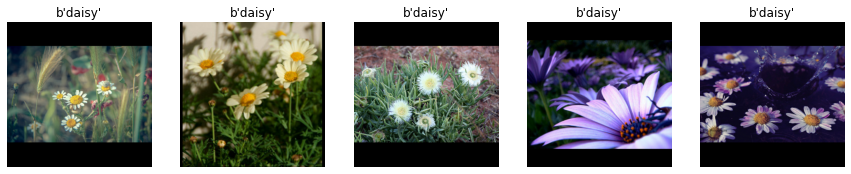

In [4]:
ds = tf.data.experimental.make_batched_features_dataset(
    './flower_tftransform/train-00000-of-00016.gz',
    batch_size=5,
    features = {
        'image': tf.io.FixedLenFeature([IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS], tf.float32),
        'label': tf.io.FixedLenFeature([], tf.string),
        'label_int': tf.io.FixedLenFeature([], tf.int64)
    },
    reader=lambda filenames: tf.data.TFRecordDataset(filenames, compression_type='GZIP')
)
for feats in ds.take(1):
    print(feats['image'].shape)

f, ax = plt.subplots(1, 5, figsize=(15,15))
for feats in ds.take(1):
    for idx in range(5): # batchsize
        ax[idx].imshow((feats['image'][idx].numpy()));
        ax[idx].set_title(feats['label'][idx].numpy())
        ax[idx].axis('off')

## Train the model

In [5]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

In [6]:
import tensorflow_hub as hub
import os
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'    

def create_preproc_dataset(pattern, batch_size):
    return tf.data.experimental.make_batched_features_dataset(
        pattern,
        batch_size=batch_size,
        features = {
            'image': tf.io.FixedLenFeature([IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS], tf.float32),
            'label': tf.io.FixedLenFeature([], tf.string),
            'label_int': tf.io.FixedLenFeature([], tf.int64)
        },
        reader=lambda filenames: tf.data.TFRecordDataset(filenames, compression_type='GZIP'),
        num_epochs=1
    ).map(
        lambda x: (x['image'], x['label_int'])
    )

# parameterize to the values in the previous cell
# WARNING! training on a small subset dataset (note top_dir)
def train_and_evaluate(top_dir='./flower_tftransform',
                       batch_size = 32,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)
    
    train_dataset = create_preproc_dataset(os.path.join(top_dir, 'train-*'), batch_size)
    eval_dataset = create_preproc_dataset(os.path.join(top_dir, 'valid-*'), batch_size)

    layers = [
      tf.keras.layers.experimental.preprocessing.CenterCrop(
          height=IMG_HEIGHT//2, width=IMG_WIDTH//2,
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
      ),
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation=tf.keras.activations.relu,
                            name='dense_hidden'),
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
    ]

    model = tf.keras.Sequential(layers, name='flower_classification')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
    print(model.summary())
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=3)
    training_plot(['loss', 'accuracy'], history)
    return model

Model: "flower_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
center_crop (CenterCrop)     (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenet_embedding (KerasLa (None, 1280)              2257984   
_________________________________________________________________
dense_hidden (Dense)         (None, 16)                20496     
_________________________________________________________________
flower_prob (Dense)          (None, 5)                 85        
Total params: 2,278,565
Trainable params: 20,581
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/3
3/3 [==============================] - 4s 1s/step - loss: 2.7983 - accuracy: 0.1098 - val_loss: 0.8237 - val_accuracy: 0.8462
Epoch 2/3
3/3 [==============================] - 2s 592ms/step - loss: 0.5661 - accurac

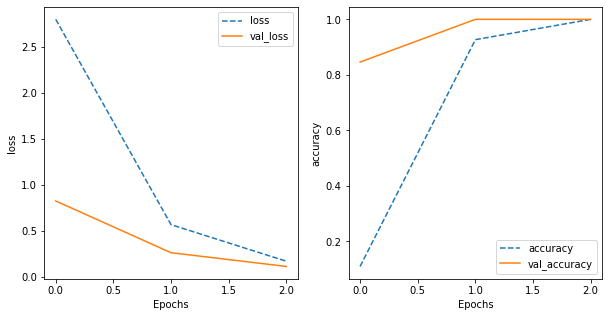

In [7]:
model = train_and_evaluate()

## Predictions

For serving, we will write a serving function that calls the transform model
followed by our actual model.

We will look at serving functions in Chapter 7. For now, we show how to explicitly
call the transform function followed by model.predict()

In [8]:
!saved_model_cli show --all --dir ./flower_tftransform/tft/transform_fn


MetaGraphDef with tag-set: 'transform' contains the following SignatureDefs:

signature_def['transform_signature']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['img_bytes'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: inputs/F_img_bytes:0
    inputs['label'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: inputs/label:0
    inputs['label_int'] tensor_info:
        dtype: DT_INT64
        shape: (-1)
        name: inputs/F_label_int:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 448, 448, 3)
        name: map/TensorArrayV2Stack/TensorListStack:0
    outputs['label'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: inputs/inputs/label_copy:0
    outputs['label_int'] tensor_info:
        dtype: DT_INT64
        shape: (-1)
        name: inputs/inputs/F_label_int_copy:0
  Method 

In [9]:
# get some files to do inference on.
filenames = [
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9818247_e2eac18894.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/98992760_53ed1d26a9.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9939430464_5f5861ebab.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9965757055_ff01b5ee6f_n.jpg'
]
img_bytes = [
    tf.io.read_file(filename) for filename in filenames
]
label = [
    'n/a' for filename in filenames
] # not used in inference
label_int = [
    -1 for filename in filenames
] # not used in inference

# by calling the preproc function, we get images of the right size & crop
preproc = tf.keras.models.load_model('./flower_tftransform/tft/transform_fn').signatures['transform_signature']
preprocessed = preproc(img_bytes=tf.convert_to_tensor(img_bytes), 
                       label=tf.convert_to_tensor(label, dtype=tf.string), 
                       label_int=tf.convert_to_tensor(label_int, dtype=tf.int64))

# then we call model.predict() and take the argmx of the result
pred_label_index = tf.math.argmax(model.predict(preprocessed)).numpy()
print(pred_label_index)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['label', 'image', 'label_int'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


[3 4 1 4 4]


## License
Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.